# Task one

# Mathematical background

## Fitting single harmonics [1]

We fit single harmonics to the anomalous data (data values minus the mean) using a Fourier transform to find the coefficients 
$$ A_k = \frac{2}{n}\sum_{i=1}^{n}y_n\cos\left(\frac{2\pi i k}{n}\right)$$
and
$$ B_k = \frac{2}{n}\sum_{i=1}^{n}y_n\sin\left(\frac{2\pi i k}{n}\right)$$
of
$$ y_i - \overline{y} = A_k \cos\left(\frac{2\pi i k}{n}\right) + B_k \sin\left(\frac{2\pi i k}{n}\right) $$

Here $k$ is the harmonic being fitted to the anomaly of some data.
To carry this out we write a function `fourier_coeffs` to which calculates $A_{k}$ and $B_{k}$ as well as functions to compute the sine and cosine sums.

This will be used for both water and air temperature to fit a few discrete harmonics.

In [42]:
function fourier_coeffs(y, k)
    n = length(y)
    i = 1:n
    Aₖ = (2 / n) * sum(y .* cos.((2 * π * i * k) / n))
    Bₖ = (2 / n) * sum(y .* sin.((2 * π * i * k) / n))
    return [Aₖ, Bₖ]
end

fourier_coeffs (generic function with 1 method)

In [43]:
@. cosfunc(i, k, N) = sum( cos( (2*π*i*k) / N) )
@. sinfunc(i, k, N) = sum( sin( (2*π*i*k) / N) )

sinfunc (generic function with 1 method)

## Spectral density [1]

We can look at the spectral density of the sea level by using a power spectrum (or periodogram) to see how the processes at different speed contribute to a time series.
This arises by considering the Fourier coefficients $A_{k}$ and $B_{k}$ above as functions of frequency - that is how 
$$
C_{k}^{2} = A_{k}^{2} + B_{k}^{2}
$$
varies as the frequency $f_{k} = $ varies.

In doing so we encounter the *Nyquist frequency* and aliasing errors.
The *Nyquist frequency* executes $\frac{n}{2}$ cycles over the full data and depends on the temporal resolution of the data.
This limits the information available from and spectral analysis because there are only so many allowable frequencies for a data set that are determined by the number of cycles in the data.
Hence the spectra are only computed up to this $n$ determined by the Nyquist frequency. 

This can be computed by using the function `C_k` below which computes $C_{k}$ from the function `fourier_coeffs`.
The *Nyquist frequency* determines the value $n$ so for the periodogram we compute the $C_{k}$ corresponding to the $\frac{n}{2}-1$ spectra then determine the $A_{k}$ and $B_{k}$ coefficients for $\frac{n}{2}$ by
$$
A_{n/2} = 
\begin{cases}
    \frac{1}{n} \sum_{i}^{n}y_{i}\cos(\pi i) & n \text{ even} \\
    0 & n \text{ odd} 
\end{cases}
$$
and 
$$
B_{n/2} = 
\begin{cases}
    0 & n \text{ even} \\
    0 & n \text{ odd} 
\end{cases}
$$

In [3]:
function C_k(y, k)
    F_coeffs = fourier_coeffs(y, k)
    return F_coeffs[1]^2 + F_coeffs[2]^2
end

C_k (generic function with 1 method)

The above function will compute the appropriate Fourier coefficients however it is not very well optimised and as this data set is reasonably large we can use the `FFTW.jl` package instead.
This uses the much more efficient fast Fourier transform algorithm to compute the complex Fourier coefficients for the data for all $k$.
Depending on the *Nyquist frequency* we then take the required coefficients from this set of complex Fourier coefficients (for the complex Fourier coefficients the real part $A_{k}$ and the imagainary part is $B_{k}$).

The periodograms looked at will be Fourier coefficient $C_{k}$ against freqeuncy $f_{k} = \frac{k}{n}$.
This will give an indication of which frequencies are important which can be related to a period by
$$
\tau_{k} = \frac{1}{f_{k}}.
$$

# Data

I have chosen to look at the data collected from Port Vila (on the island of Efate, Vanuatu) in 2017.
The data and metadata were downloaded from [here](http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml) with further metadata (e.g. units of measurements, errors etc.) found [here](http://www.bom.gov.au/oceanography/projects/spslcmp/data/data.shtml).

The data contains hourly observations recorded between midnight (Universal Time Cooridnated time UTC) 1st January 2017 and 23:00 (UTC) 31st December 2017 of:
* sea Level (metres above tide gauge = 0)
* water temperature (degrees celsius)
* air temperature (degrees celsius)
* barometric pressure (hectopascals)
* residuals (measure of discrepancy between observed sea level and predicted sea level, metres)
* adjusted residuals (measure of discrepancy between observed sea level and predicted sea level adjusted for static barometric pressure effect, metres)
* wind direction (degrees true)
* wind gust (metres per second)
* wind speed (metres per second)

from latitude 17° 45' 41" S and longtitude 168° 17' 35" E.

The total number of observations recorded is 8760.
## Source of data

The data is provided by the Australian Bureau of Meterology and comes from the *Pacific Sea Level and Geodetic Monitoring Project*.

## Display and describe data

First load in the data and see inspect it using summaries and plots.
For this task we are interested in the water temperature, the air temperature and the sea level so we only read in these columns along with the date and time (rather than the whole file).

In [4]:
using Pkg
#Pkg.add(["CSV", "DataFrames", "Plots", "Dates", "Statistics", "FFTW", "Suppressor"])
Pkg.activate("..")

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


In [5]:
using CSV, DataFrames, Plots, Dates, Statistics, FFTW, Suppressor

In [6]:
vanuatu_2017 = @suppress begin #This is just to suppress unnecessary warnings
    CSV.File("IDO70009_2017.csv"; drop = ["Barometric Pressure", "Residuals", "Adjusted Residuals", "Wind Direction", "Wind Gust", "Wind Speed", "Vanuatu"]) 
end
df_van = DataFrame(vanuatu_2017) 
first(df_van, 10)

,Date & UTC Time,Sea Level,Water Temperature,Air Temperature
,String31,Float64,Float64,Float64
1,01-Jan-2017 00:00,1.007,28.0,27.5
2,01-Jan-2017 01:00,0.88,28.0,28.0
3,01-Jan-2017 02:00,0.799,28.0,28.2
4,01-Jan-2017 03:00,0.787,28.1,27.0
5,01-Jan-2017 04:00,0.864,28.1,26.9
6,01-Jan-2017 05:00,1.004,27.9,27.4
7,01-Jan-2017 06:00,1.169,27.9,26.9
8,01-Jan-2017 07:00,1.299,27.9,24.2
9,01-Jan-2017 08:00,1.366,27.9,24.5


In [7]:
describe(df_van)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,Date & UTC Time,,01-Apr-2017 00:00,,31-Oct-2017 23:00,0
2,Sea Level,-32.2527,-9999.0,0.86,1.611,0
3,Water Temperature,-139.772,-9999.0,27.0,31.0,0
4,Air Temperature,-7.48828,-9999.0,25.6,32.7,0


In total there are 8760 observations.
From the summaray of the data above there are minimum entries in all measureable columns of -9999. 
We do not remove these errors here as we may remove a row that has an error in one variable but not another.
Instead we reomve the errors in the single variable data frames below.
As well the date and time minimum and maximum are related to alphabetical ordering rather then temporal ordering as they are strings.
Using the `Dates.jl` package we create a new column for the date and time which orders things temporally.
These entries are **errors in the data** so below, when we are working in smaller dataframes, these are removed before plotting and fitting harmonics or spectral density power.

For convenience the variables are renamed to something without white space and a little shorter.

In [8]:
rename!(df_van, ["datetime", "sea_level", "water_temp", "air_temp"]);

The `datetime` variable is a string however julia has a package to deal with dates which we are going to use.
To take advantage of the `Dates.jl` package, we need to create a new column that has date and time in a julia `DateTime` format.
This is done below then we take another look at the desecription of the data and see the new date time column has minimum of the first entry and maximum of the last entry.
This is not strictly necessary except that it is easier to work with these `DateTime` formats than strings later on.

In [9]:
new_date = DateTime(2017, 1, 1, 00, 00, 00):Dates.Hour(1):DateTime(2017, 12, 31, 23, 00, 00)
insertcols!(df_van, 2, :datetime2 => new_date)
describe(df_van)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime,,01-Apr-2017 00:00,,31-Oct-2017 23:00,0
2,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
3,sea_level,-32.2527,-9999.0,0.86,1.611,0
4,water_temp,-139.772,-9999.0,27.0,31.0,0
5,air_temp,-7.48828,-9999.0,25.6,32.7,0


## Extract and clean data for `Sea level`, `Water Temperature`, and `Air Temperature`.
We are interested in the `Sea level`, `Water Temperature`, and `Air Temperature`, so we can create separate `DataFrames` for each of these variables (that also includes the date and time).

For `Water Temperature` and `Air Temperature` the data is cleaned and we look to fit some harmonics to the data.
For `Sea level` we do the same then look to compute the spectral density of the data.

In [10]:
sea_lvl = select(df_van, :datetime2, :sea_level)
w_temp = select(df_van, :datetime2, :water_temp)
a_temp = select(df_van, :datetime2, :air_temp);

Now we take a look at these dataframes individually

## Water temperature

First look at what the data for water temperature.
The summary below shows there are errors (given value -9999.0) so we remove all observations from `w_temp` that take the value -9999.0.

In [11]:
find = findall(w_temp[:, 2] .== -9999.0)
delete!(w_temp, find);

Now we check the plot and description of the data and see if this has taken care of things or if more needs to be done.

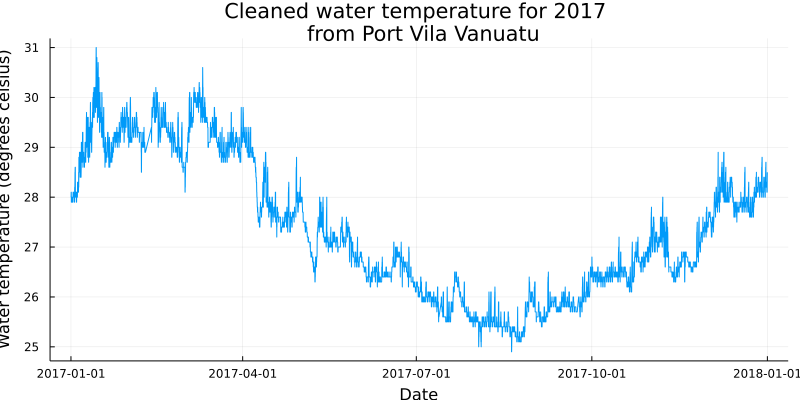

In [34]:
plot(w_temp[:, 1], w_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = false, 
    title = "Cleaned water temperature for 2017 \n from Port Vila Vanuatu",
    size = (800, 400))

In [13]:
describe(w_temp)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
2,water_temp,27.334,24.9,27.1,31.0,0


Removal of these errors seems to have taken care things.
The mean water temperature and median are close (27.334 and 27.1 respectively) and the water is warmest in the summer months, drops through autumn and is lowest in winter.

We are interested in the anomaly so we fit this then insert it into the data frame.
Now we look to fit discrete harmonics to the temperature anomaly data.
First get the water temperature anomaly data

In [14]:
wtemp_anom = w_temp[:, 2] .- mean(w_temp[:, 2])
insertcols!(w_temp, :w_anom => wtemp_anom)
first(w_temp, 5)

,datetime2,water_temp,w_anom
,DateTime,Float64,Float64
1,2017-01-01T00:00:00,28.0,0.666032
2,2017-01-01T01:00:00,28.0,0.666032
3,2017-01-01T02:00:00,28.0,0.666032
4,2017-01-01T03:00:00,28.1,0.766032
5,2017-01-01T04:00:00,28.1,0.766032


The harmonics are fitted using the `fourier_coeffs` function.
We will fit harmonics for $k = 1, 2, 3, 4$.

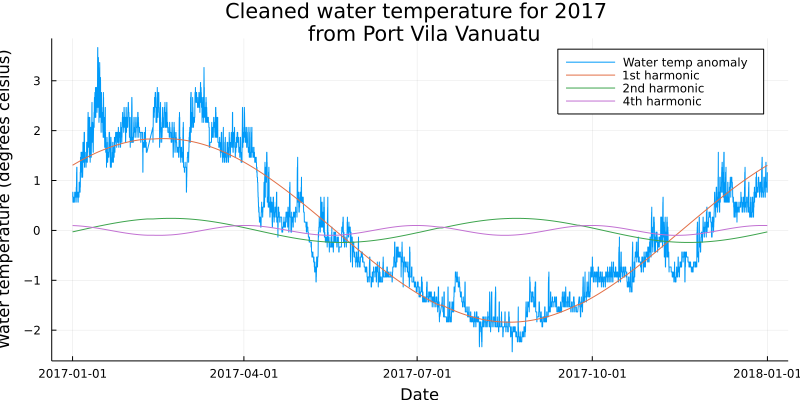

In [35]:
N = length(w_temp[:, 3])
i = range(1, N, step = 1)
k = [1, 2, 4]

# First harmonic
w_coeffs = fourier_coeffs(w_temp[:, 3], k[1])
water_first_harmonic = w_coeffs[1] * cosfunc(i, k[1], N) + w_coeffs[2] * sinfunc(i, k[1], N)
# Second harmonic 
w_coeffs = fourier_coeffs(w_temp[:, 3], k[2])
water_second_harmonic = w_coeffs[1] * cosfunc(i, k[2], N) + w_coeffs[2] * sinfunc(i, k[2], N)
# Fourth harmonic 
w_coeffs = fourier_coeffs(w_temp[:, 3], k[3])
water_fourth_harmonic = w_coeffs[1] * cosfunc(i, k[3], N) + w_coeffs[2] * sinfunc(i, k[3], N)

plot(w_temp[:, 1], w_temp[:, 3], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = "Water temp anomaly", 
    title = "Cleaned water temperature for 2017 \n from Port Vila Vanuatu",
    size = (800, 400))
plot!(w_temp[:, 1], water_first_harmonic, label = "1st harmonic")
plot!(w_temp[:, 1], water_second_harmonic, label = "2nd harmonic")
plot!(w_temp[:, 1], water_fourth_harmonic, label = "4th harmonic")


As there is only one macro cycle in this data (the annual warming and cooling of water temperature) and we have the data for one year the first harmonic does the best job of fitting.

The fit of the of the fourth harmonic is able to capture some of the smaller variations of the macro cycle but (unsurprisingly) neither the the second or the fourth harmonic provide much of a fit as we only have the data for one year.

The seasonal cycle can now be removed by subtracting the first harmonic from the temperature anomaly data.

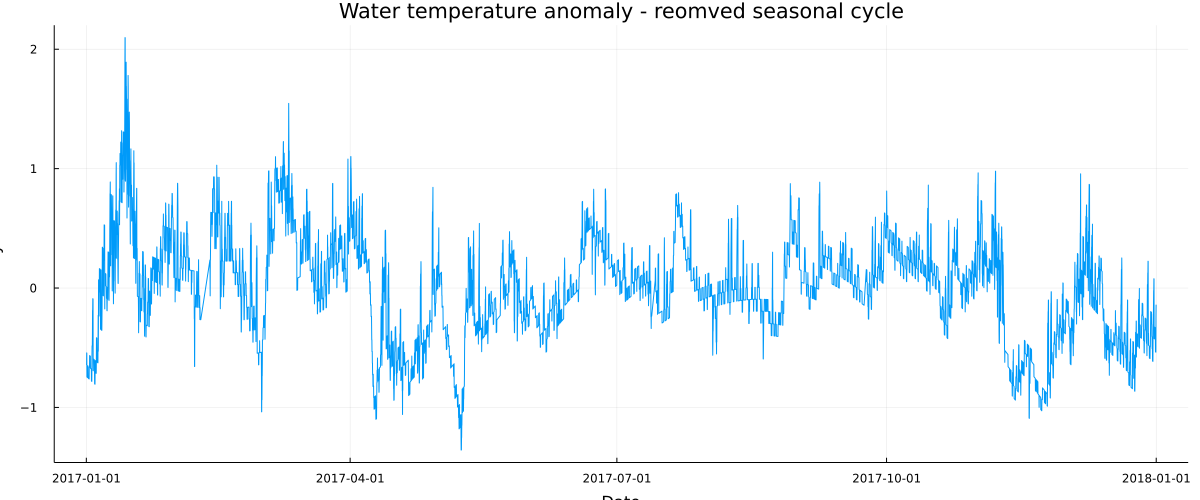

In [16]:
plot(w_temp[:, 1], w_temp[:, 3] .- water_first_harmonic, 
    xlabel = "Date", 
    ylabel = "water anomaly - 1st harmonic", 
    title = "Water temperature anomaly - reomved seasonal cycle",
    label = false,
    size = (800, 400))

## Air temperature
Again remove the data entries corresponding to -9999.0 which are errors.

In [17]:
describe(a_temp)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
2,air_temp,-7.48828,-9999.0,25.6,32.7,0


In [18]:
find = findall(a_temp[:, 2] .== -9999.0)
delete!(a_temp, find);

Now we check to see if this has cleaned things up.

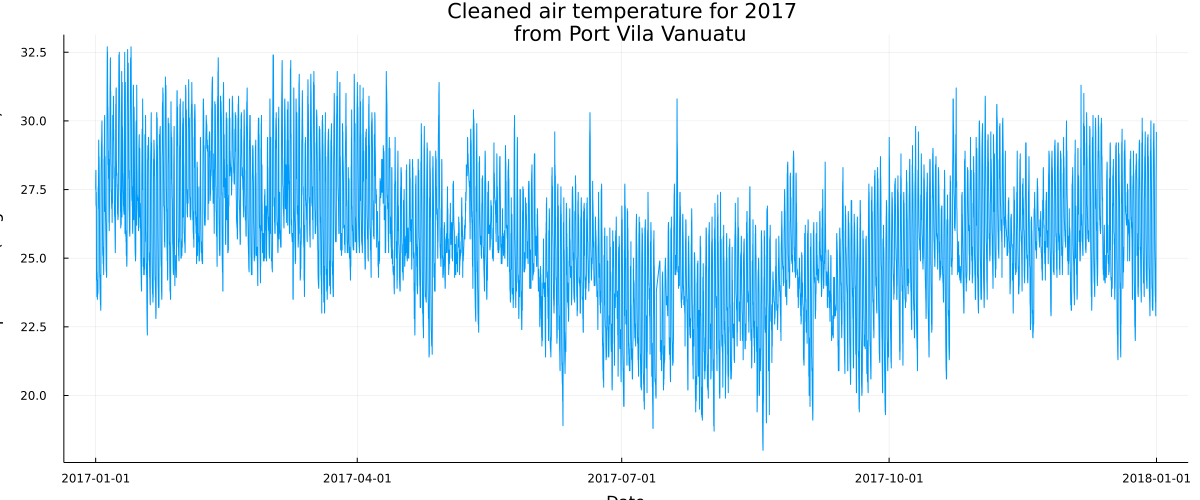

In [19]:
plot(a_temp[:, 1], a_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Air temperature (degrees celsius)",
    label = false, 
    title = "Cleaned air temperature for 2017 \n from Port Vila Vanuatu",
    size = (800, 400))

In [20]:
describe(a_temp)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
2,air_temp,25.6985,18.0,25.6,32.7,0


Again this has cleared things up.
The mean and median are now much closer (almost the same) and the air temperature follows the annual cycle of warmer in summer and cooler in winter.

We now fit some harmonics to the air temperature anomaly.
As this is also an annual shift from warmer to cooler, and we have one years worth of data, we expect that the first harmonic will best fit similarly to the water temperature anomaly.

In [21]:
atemp_anom = a_temp[:, 2] .- mean(a_temp[:, 2])
insertcols!(a_temp, :a_anom => atemp_anom)
first(a_temp, 5)

,datetime2,air_temp,a_anom
,DateTime,Float64,Float64
1,2017-01-01T00:00:00,27.5,1.80149
2,2017-01-01T01:00:00,28.0,2.30149
3,2017-01-01T02:00:00,28.2,2.50149
4,2017-01-01T03:00:00,27.0,1.30149
5,2017-01-01T04:00:00,26.9,1.20149


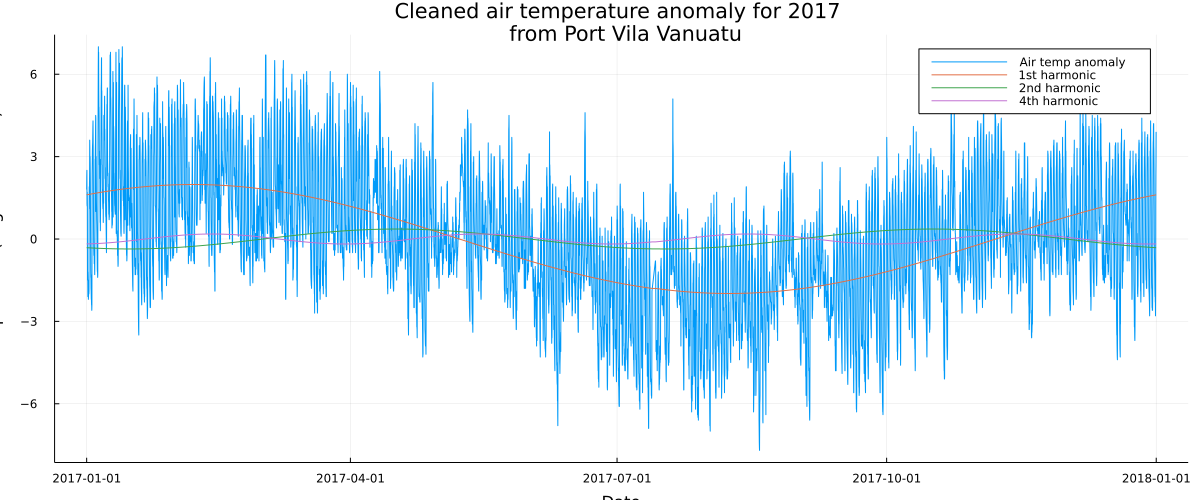

In [22]:
N = length(a_temp[:, 3])
i = range(1, N, step = 1)
k = [1, 2, 4]

# First harmonic
a_coeffs = fourier_coeffs(a_temp[:, 3], k[1])
air_first_harmonic = a_coeffs[1] * cosfunc(i, k[1], N) + a_coeffs[2] * sinfunc(i, k[1], N)
# Second harmonic 
a_coeffs = fourier_coeffs(a_temp[:, 3], k[2])
air_second_harmonic = a_coeffs[1] * cosfunc(i, k[2], N) + a_coeffs[2] * sinfunc(i, k[2], N)
# Fourth harmonic 
a_coeffs = fourier_coeffs(a_temp[:, 3], k[3])
air_fourth_harmonic = a_coeffs[1] * cosfunc(i, k[3], N) + a_coeffs[2] * sinfunc(i, k[3], N)

plot(a_temp[:, 1], atemp_anom, 
    xlabel = "Date",
    ylabel = "Air temperature (degrees celsius)",
    label = "Air temp anomaly", 
    title = "Cleaned air temperature anomaly for 2017 \n from Port Vila Vanuatu",
    size = (800, 400))
plot!(a_temp[:, 1], air_first_harmonic, label = "1st harmonic")
plot!(a_temp[:, 1], air_second_harmonic, label = "2nd harmonic")
plot!(a_temp[:, 1], air_fourth_harmonic, label = "4th harmonic")


As with the water temperature anomaly we have one year of data and the cycle is annual hence the 1st harmonic fits well to the data.
The second and fourth harmonic reveal very little here.

Using the first harmonic the seasonal variation can be removed as was done for the water temperature anomaly.

# Sea level
Again there is data corresponding to -9999.0 that needs to be removed.

In [23]:
find = findall(sea_lvl[:, 2] .== -9999.0)
delete!(sea_lvl, find);

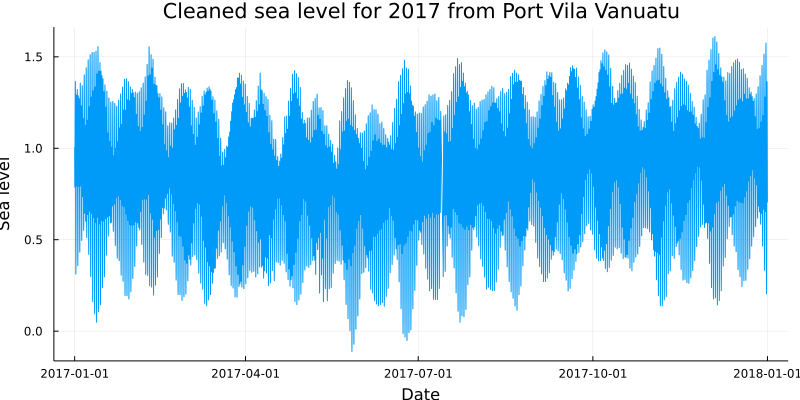

In [32]:
plot(sea_lvl[:, 1], sea_lvl[:, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 from Port Vila Vanuatu",
    size = (800, 400))

In [25]:
describe(sea_lvl)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
2,sea_level,0.851854,-0.111,0.861,1.611,0


Again removing the observations that were entered as -9999.0 has cleared things up.
There are now

In [36]:
length(sea_lvl[:, 1])

8731

observations in the data.

## Periodogram

We now fit a periodogram to the sea level data.
This will provide information about which frequencies contain power.

### Fourier coefficients

Compute the Fourier coefficients using the real fast Fourier transfrom `rfft` from `FFTW.jl`.

In [37]:
sealvl_coeffs = (2 / N) .* rfft(sea_lvl[:, 2], 1)
Cₖ = abs.(sealvl_coeffs);

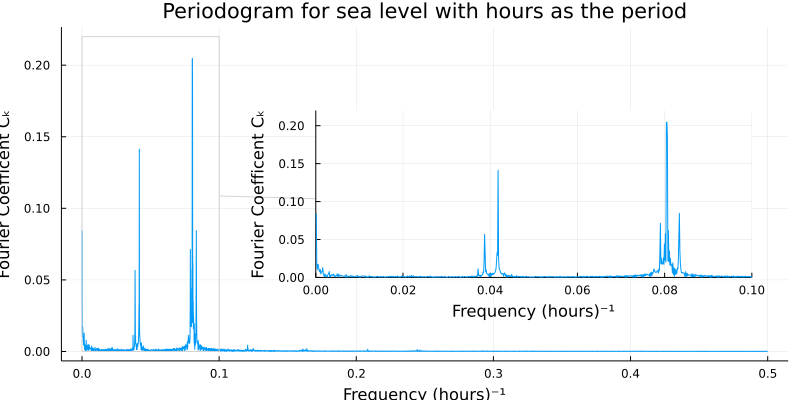

In [41]:
sealvl_coeffs = (2 / N) .* rfft(sea_lvl[:, 2], 1)
Cₖ = abs.(sealvl_coeffs) # Fourier coefficients

N = length(sea_lvl[:, 1]) #total number of hourly observations
fₖ = (1:round(Int64, N / 2) - 1) ./ N #frequencies

plot(fₖ, Cₖ[2:round(Int64, N / 2) ], # julia indexes from 1 so we only consider ffrom the second entry which is 2, rather than 1 in python.
    xlabel = "Frequency (hours)⁻¹",
    ylabel = "Fourier Coefficent Cₖ",
    title = "Periodogram for sea level with hours as the period",
    label = false,
    size = (800, 400))
lens!([0, 0.1], [0.0, 0.22], inset = (1, bbox(0.35, 0.25, 0.6, 0.5)), xlabel = "Frequency (hours)⁻¹", ylabel = "Fourier Coefficent Cₖ")

From the periodogram we see that frequencies with the most power occur very close to the beginning, just after $f_{k} = 0.04$ and just after $f_{k} = 0.08$.
We can locate the highest frequency using `findmax`,

In [92]:
fₖ_max = findmax(Cₖ[2:round(Int64, N / 2) ])

(0.204753266834779, 703)

This occurs at index 703 so the associated frequency and period is

In [100]:
println("Higest frequency "*string(fₖ[703]))
period = 1/fₖ[703]
println("Corresponding period is "*string(period))

Higest frequency 0.08051769556751803
Corresponding period is 12.419630156472262


So the period of 12.42 hours has the most power in this time series.
This aligns well with the changing of high to low tide that occurs approximately every 12.5 hours and is represented in the plot of one day of sea level data directly below.

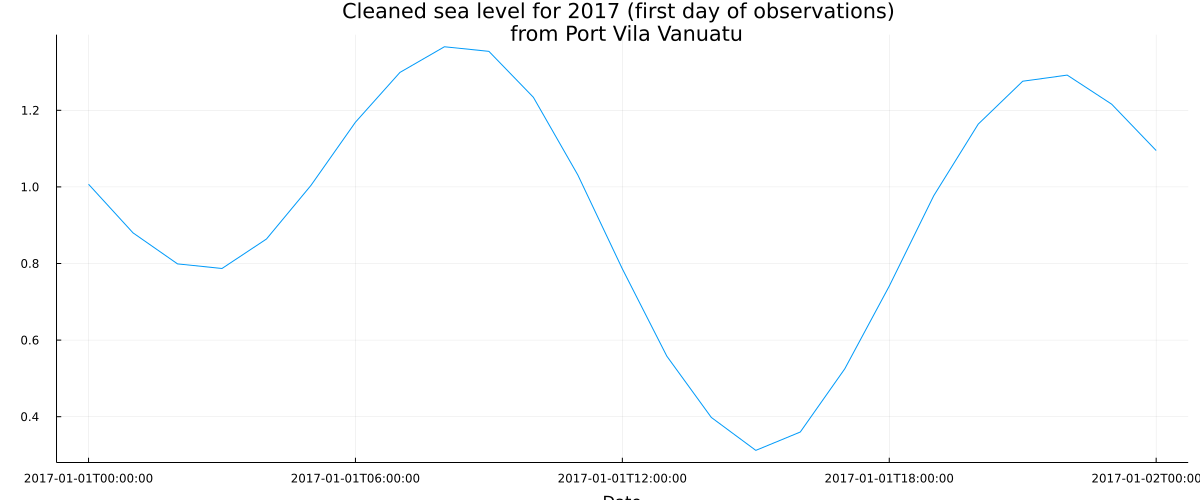

In [129]:
find_day = findfirst(sea_lvl[:, 1] .== DateTime(2017, 1, 2, 00, 00, 00))
plot(sea_lvl[1:find_day, 1], sea_lvl[1:find_day, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 (first day of observations) \n from Port Vila Vanuatu",
    size = (800, 400))

By sorting the frequency from highest to lowest we can look to find the other peak in power around $f_{k} = 0.04$.

In [127]:
sorted_Cₖ = sort(Cₖ, rev = true)
second_peak = sorted_Cₖ[5]
third_peak = sorted_Cₖ[7]

find_second_peak = findall(Cₖ .== second_peak)[1]
find_third_peak = findall(Cₖ .== third_peak)[1]
println("Second frequency "*string(fₖ[find_second_peak]))
period2 = 1/fₖ[find_second_peak]
println("Corresponding period "*string(period2))

Second frequency 0.041919596838850076
Corresponding period 23.8551912568306


So the other main period is 24 hours.
This is likely just catching some of the 12 hour cycle of the tide rather than an actual 24 hour pattern.

Here we have found out important information from about the period of the tide from the periodogram, no doubt more can be done with this time series!

# References

[1]
Wilks, Daniel S. *Statistical methods in the atmospheric sciences 4th edition*